# Description:

* number libraries = 1
* isotope incorp: 0% for all taxa (baseline)

## Goals:

* assess how fragment length affects distribution of amplicon fragments
  * fragment distributions:
    * uniform, large range
    * uniform, all small fragments
    * uniform, all large fragments
    * skewed normal, 4 kb size cutoff
    * skewed normal, 0.5 kb size cutoff

# Init

In [2]:
workDir = '/home/nick/notebook/SIPSim/dev/bac_genome_all/nl1/fragLen/'
baseDir = '/home/nick/notebook/SIPSim/dev/bac_genome_all/'
SIPSimExe = '/home/nick/notebook/SIPSim/SIPSim'

In [3]:
import os,sys
import numpy as np
import pandas as pd
from ggplot import *
import matplotlib.pyplot as plt

In [4]:
%load_ext rpy2.ipython
%matplotlib inline

In [5]:
%%R
library(ggplot2)
library(dplyr)
library(tidyr)
library(gridExtra)
library(data.table)


Attaching package: ‘dplyr’

The following object is masked from ‘package:stats’:

    filter

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: grid
data.table 1.9.4  For help type: ?data.table
*** NB: by=.EACHI is now explicit. See README to restore previous behaviour.

Attaching package: ‘data.table’

The following objects are masked from ‘package:dplyr’:

    between, last



In [6]:
if not os.path.isdir(workDir):
    os.mkdir(workDir)

# Simulating gradient communities

In [118]:
!cd $workDir; \
    $SIPSimExe gradientComms \
    --abund_dist power \
    --abund_dist_p a:100 \
    $baseDir/genomes/taxon_index.txt > comm-n1-pow.txt

[1] 100
     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
0.0000575 0.0248400 0.0554400 0.0826400 0.1203000 0.7323000 
[1] 12727.77


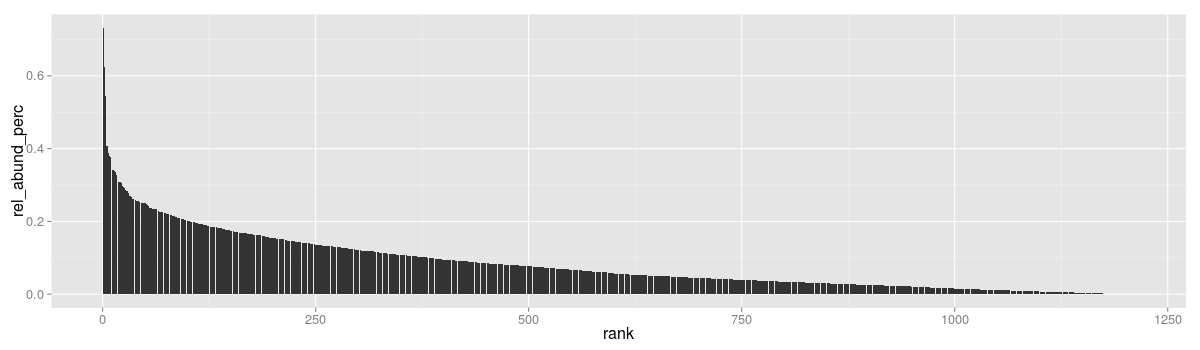

In [122]:
%%R -i workDir -w 1200 -h 350 
# plotting the abundance distribution
setwd(workDir)

tbl = read.delim('comm-n1-pow.txt', sep='\t')

print(sum(tbl$rel_abund_perc))
print(summary(tbl$rel_abund_perc))
print(max(tbl$rel_abund_perc) / min(tbl$rel_abund_perc))

# plotting
ggplot(tbl, aes(rank, rel_abund_perc)) +
    geom_bar(stat='identity') +
    theme( text = element_text(size=16))

# Simulating isotope incorporation

In [123]:
# making config file
config = """
[library 1]
  # baseline: no incorp
  
  [[intraPopDist 1]]
  distribution = uniform
  weight = 1

    [[[start]]]

      [[[[interPopDist 1]]]]
        distribution = uniform
        start = 0
        end = 0

    [[[end]]]

      [[[[interPopDist 1]]]]
        distribution = uniform
        start = 0
        end = 0
"""

outfile = os.path.join(workDir, 'incorp.config')

outf = open(outfile, 'wb')
outf.write(config)
outf.close()

In [126]:
!cd $workDir; \
     $SIPSimExe isoIncorp comm-n1-pow.txt incorp.config > incorp-n1-pow.txt

In [127]:
!cd $workDir; head incorp-n1-pow.txt

library	taxon_name	distribution_index	distribution	weight	param	param_value
1	Isosphaera_pallida_ATCC_43644	1	uniform	1.0	start	8.41134849099e-07
1	Isosphaera_pallida_ATCC_43644	1	uniform	1.0	end	3.86213774981e-06
1	Caulobacter_crescentus_NA1000	1	uniform	1.0	start	4.7095790248e-06
1	Caulobacter_crescentus_NA1000	1	uniform	1.0	end	7.22092768592e-06
1	Candidatus_Liberibacter_solanacearum_CLso-ZC1	1	uniform	1.0	start	7.47050104396e-06
1	Candidatus_Liberibacter_solanacearum_CLso-ZC1	1	uniform	1.0	end	3.75886172964e-06
1	Rickettsia_parkeri_str_Portsmouth	1	uniform	1.0	start	7.79689107526e-06
1	Rickettsia_parkeri_str_Portsmouth	1	uniform	1.0	end	6.51117262806e-06
1	Chlamydophila_abortus_S26_3	1	uniform	1.0	start	8.31779429734e-06


# Simulating gradient fractions

In [138]:
!cd $workDir; \
    $SIPSimExe fractions comm-n1-pow.txt > fracs-n1-pow.txt

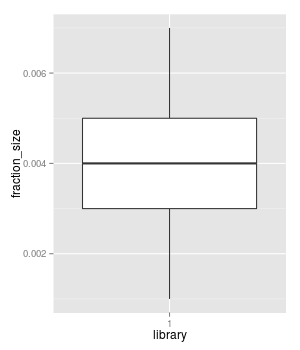

In [145]:
%%R -i workDir -h 350 -w 300 
# plotting the abundance distribution
setwd(workDir)

tbl = read.delim('fracs-n1-pow.txt', sep='\t')
tbl$library = as.character(tbl$library)

#tbl.m = tbl %>% gather(min_max, BD, BD_min:BD_max )
#ggplot(tbl.m, aes(fraction, BD, group=fraction, color=min_max)) +
#    geom_point() +
#    geom_line(color='black')


ggplot(tbl, aes(library, fraction_size)) +
    geom_boxplot()

# Simulating amplicon fragments & calculating GC

## Uniform fragment length distribution: large range

* 10k amplicon-fragments per genome

In [65]:
!cd $workDir; \
    $SIPSimExe fragGC \
    $baseDir/genomes/genome_index.txt \
    --fp $baseDir/genomes/ \
    --fr $baseDir/515Fm-927Rm.fna \
    --fld uniform,500,15000 \
    --flr 500,None \
    --nf 10000 \
    --np 24 \
    2> ampFragGC_unif5-150.log \
    > ampFragGC_unif5-150.pkl

## Creating OTU table

In [ ]:
!cd $workDir; \
    $SIPSimExe OTU_table \
    ampFragGC_unif5-150.pkl \
    comm-n1-pow.txt \
    incorp-n1-pow.txt \
    fracs-n1-pow.txt \
    --abs_abund 1e9 \
    2> OTU-n1-exp_unif5-150_A1e9.log \
    > OTU-n1-exp_unif5-150_A1e9.txt

## Plotting OTU table

In [ ]:
%%R -i workDir

# loading file
infile = paste(c(workDir, 'OTU-n1-exp_unif5-150_A1e9.txt'), collapse='/')
tbl = read.csv(infile, sep='\t')

# formatting table
tbl$BD_min = gsub('-.+', '', tbl$fractions)
tbl$BD_min = as.numeric(tbl$BD_min)
tbl$BD_max = gsub('.+-', '', tbl$fractions)
tbl$BD_max = as.numeric(tbl$BD_max)

In [ ]:
%%R

# summarizing counts (should be approx. total abundance)
tbl %>%
    group_by(library) %>%
    summarize(sum(count))

In [ ]:
%%R

# summarizing counts (should be approx. total abundance)
tbl %>%
    group_by(BD_min) %>%
    summarize(sum(count)) %>% as.data.frame

In [ ]:
%%R
## BD for G+C of 0 or 100
BD.GCp0 = 0 * 0.098 + 1.66
BD.GCp100 = 1 * 0.098 + 1.66

In [ ]:
%%R -w 800 -h 350
# plotting absolute abundances

tbl.s = tbl %>%
    group_by(BD_min) %>%
    summarize(total_count = sum(count))


## plot
p = ggplot(tbl.s, aes(BD_min, total_count)) +
    geom_area(stat='identity', alpha=0.5, position='dodge') +
    geom_vline(xintercept=c(BD.GCp0, BD.GCp100), linetype='dashed', alpha=0.5) +
    labs(x='Buoyant density') +
    theme( 
        text = element_text(size=16) 
    )
p

In [ ]:
%%R -w 800 -h 350

p + scale_y_log10()

In [ ]:
%%R -w 800 -h 350
# plotting relative abundances

## plot
p = ggplot(tbl, aes(BD_min, count, fill=taxon, group=taxon)) +
    geom_area(stat='identity', alpha=0.5, position='fill') +
    geom_vline(xintercept=c(BD.GCp0, BD.GCp100), linetype='dashed', alpha=0.5) +
    labs(x='Buoyant density') +
    theme( 
        text = element_text(size=16),
        legend.position = 'none'
    )
p

In [ ]:
%%R -w 800 -h 350
# plotting number of taxa at each BD

tbl.nt = tbl %>%
    filter(count > 0) %>%
    group_by(BD_min) %>%
    summarize(n_taxa = n())

## plot
p = ggplot(tbl.nt, aes(BD_min, n_taxa)) +
    geom_area(stat='identity', alpha=0.5, position='dodge') +
    geom_vline(xintercept=c(BD.GCp0, BD.GCp100), linetype='dashed', alpha=0.5) +
    labs(x='Buoyant density', y='Number of taxa') +
    theme( 
        text = element_text(size=16),
        legend.position = 'none'
    )
p

In [ ]:
%%R
# plotting the most 

In [ ]:
%%R -w 800 -h 350
# plotting rel abunds for just very heavy BD values

BD.low.limit = 1.76
BD.high.limit = 1.8

tbl.heavy = tbl %>%
    filter( BD_min >= BD.low.limit )

tbl.hs = tbl.heavy %>%
    group_by(taxon) %>%
    summarize( total_abund = sum(count) ) %>%
    filter(total_abund > 0)

tbl.heavy = tbl.heavy %>%
    filter(taxon %in% tbl.hs$taxon)


## plot
p = ggplot(tbl.heavy, aes(BD_min, count, fill=taxon, group=taxon)) +
    geom_area(stat='identity', alpha=0.5, position='fill') +
    scale_x_continuous( limits=c(BD.low.limit, BD.high.limit) ) +
    geom_vline(xintercept=c(BD.GCp0, BD.GCp100), linetype='dashed', alpha=0.5) +
    labs(x='Buoyant density') +
    theme( 
        text = element_text(size=16),
        legend.position = 'none'
    )
p


### Most abundant taxa

In [ ]:
%%R -i workDir

setwd(workDir)

inFile = 'comm-n1-pow.txt'
tbl.comm = read.delim(inFile, sep='\t')

head(tbl.comm)

In [ ]:
%%R -h 350 -w 600

tbl.s = tbl %>%
    group_by(taxon) %>%
    summarize( total_abund = sum(count) ) %>%
    mutate(rank = min_rank(desc(total_abund))) %>%
    arrange(rank)

ggplot(tbl.s, aes(rank, total_abund)) +
    geom_bar(stat='identity') +
    theme( text = element_text(size=16))

In [ ]:
%%R -w 800 
# plotting most abundant taxa

tbl.s.a10 = tbl.s %>%
    filter(rank <= 10)

tbl.a10 = tbl %>%
    filter(taxon %in% tbl.s.a10$taxon)

## plot
p = ggplot(tbl.a10, aes(BD_min, count, fill=taxon, group=taxon)) +
    geom_vline(xintercept=c(BD.GCp0, BD.GCp100), linetype='dashed', alpha=0.5) +
    labs(x='Buoyant density') +
    theme( 
        text = element_text(size=16),
        legend.position = 'none'
    )
p1 = p + geom_area(stat='identity', alpha=0.5, position='dodge') 
p2 = p + geom_area(stat='identity', alpha=0.5, position='fill') 

grid.arrange(p1, p2, ncol=1)